# Preprocessing + NN Playing for Beer Reviews

In [56]:
pip install liac-arff


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [57]:
pip install torch


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [58]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arff

## Load Dataset and create Dataframe

In [59]:
data = arff.load(open('../data/beer_reviews_small.arff', 'r'))
attr = np.array(data['attributes'])
numericals = [i[0] for i in attr if i[1] == 'INTEGER' or i[1] == 'REAL']
df = pd.DataFrame(data['data'], columns=attr[:, 0])
df.columns

Index(['brewery_id', 'brewery_name', 'review_time', 'review_overall',
       'review_aroma', 'review_appearance', 'review_profilename', 'beer_style',
       'review_palate', 'review_taste', 'beer_name', 'beer_abv',
       'beer_beerid'],
      dtype='object')

Use only 10% of the data

In [60]:
# from sklearn.model_selection import train_test_split
# _, df = train_test_split(df, test_size=0.1, random_state=42)

In [61]:
len(df)

168

In [62]:
df.columns

df['review_time'] = df['review_time'].apply(lambda sec: pd.Timestamp(sec, unit='s'))
display(df.head())

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,2009-02-16 20:57:03,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,2009-03-01 13:44:57,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,2009-03-01 14:10:04,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,2009-02-15 19:12:25,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,2010-12-30 18:53:26,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


## Fix Missing Values

The rows with missing brewery name for id 1193 are found through a quick google search and added. For the ones with brewery id 27 where the beers already exist with the correct brewery, so I add it based on the dataset. For the others I google with the provided data.

The missing review profilenames are set to anonynoums, but otherwise kept, because the review is still done correctly.

In [63]:
display(df[df.isna().any(axis=1)])
display(df[df['brewery_name'].isna()])

display(df[df['brewery_id'] == 1193])
df.loc[df['brewery_id'] == 1193, 'brewery_name'] = 'Crailsheimer Engel-Bräu'
df.loc[df['brewery_id'] == 1193, 'beer_name'] = df.loc[df['brewery_id'] == 1193, 'beer_name'].apply(lambda name: name.split(' WRONG')[0])
display(df[df['brewery_id'] == 1193])

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid


In [64]:
display(df[df['brewery_id'] == 27])

if (1391053 in df.index):
    df.loc[1391053, 'brewery_id'] = 24831
    df.loc[1391053, 'brewery_name'] = 'American Brewing Company'

if (1391051 in df.index):
    df.loc[1391051, 'brewery_id'] = 24831
    df.loc[1391051, 'brewery_name'] = 'American Brewing Company'

if (1391052 in df.index):  
    df.loc[1391052, 'brewery_id'] = 24831
    df.loc[1391052, 'brewery_name'] = 'American Brewing Company'

if (1391049 in df.index):  
    df.loc[1391049, 'brewery_id'] = 782
    df.loc[1391049, 'brewery_name'] = 'City Brewing Company, LLC'
    df.loc[1391049, 'beer_name'] = 'Side Pocket High Gravity Ale'

if (1391050 in df.index):  
    df.loc[1391050, 'brewery_id'] = 782
    df.loc[1391050, 'brewery_name'] = 'City Brewing Company, LLC'
    df.loc[1391050, 'beer_name'] = 'Side Pocket High Gravity Ale'

if (1391043 in df.index):  
    df.drop(1391043, inplace=True)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid


In [65]:
df.loc[df['review_profilename'].isna(), 'review_profilename'] = 'Anonymous'

In [66]:
len(df['beer_style'].unique())

13

In [67]:
display(len(df.loc[df['beer_abv'].isna(), 'beer_name'].unique()))

def create_mean(df):
    means = {}
    for style in df['beer_style'].unique():
        mean_abv = df.loc[df['beer_style'] == style, 'beer_abv'].mean()
        means[style] = round(mean_abv, 1)

    return means

def fill_mean(means, row):
    return 

means = create_mean(df)
print(means)
df.loc[df['beer_abv'].isna(), 'beer_abv'] = df.loc[df['beer_abv'].isna()].apply(lambda row: means[row['beer_style']], axis=1)

0

{'Hefeweizen': 5.0, 'English Strong Ale': 6.2, 'Foreign / Export Stout': 6.5, 'German Pilsener': 5.0, 'American Double / Imperial IPA': 7.7, 'Herbed / Spiced Beer': 4.7, 'Light Lager': 3.5, 'Oatmeal Stout': 7.2, 'American Pale Lager': 5.6, 'Rauchbier': 7.4, 'American Pale Ale (APA)': 5.5, 'American Porter': 5.8, 'Belgian Strong Dark Ale': 8.1}


In [68]:
print(df[df.isna().any(axis=1)].count())

brewery_id            0
brewery_name          0
review_time           0
review_overall        0
review_aroma          0
review_appearance     0
review_profilename    0
beer_style            0
review_palate         0
review_taste          0
beer_name             0
beer_abv              0
beer_beerid           0
dtype: int64


## Bag of Word for Brewery and Beer Name

In [69]:
from string import punctuation
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import sklearn
sklearn.set_config(transform_output="pandas")

In [70]:
PUNCT_TO_REMOVE = punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [71]:
df["brewery_name"] = df["brewery_name"].str.lower()
df["brewery_name"] = df["brewery_name"].apply(lambda text: remove_punctuation(text))

df["beer_name"] = df["beer_name"].str.lower()
df["beer_name"] = df["beer_name"].apply(lambda text: remove_punctuation(text))

df["text"] = df["brewery_name"] + " " + df["beer_name"]
df['text']

0                  vecchio birraio sausa weizen
1                      vecchio birraio red moon
2        vecchio birraio black horse black beer
3                    vecchio birraio sausa pils
4         caldera brewing company cauldron dipa
                         ...                   
163    caldera brewing company caldera pale ale
164    caldera brewing company caldera pale ale
165    caldera brewing company caldera pale ale
166    caldera brewing company caldera pale ale
167    caldera brewing company caldera pale ale
Name: text, Length: 168, dtype: object

In [72]:
cnt = Counter()
for text in df["text"].values:
    for word in text.split():
        cnt[word] += 1
        
FREQWORDS = set([w for (w, wc) in cnt.most_common(20)])

counts = list(cnt.values())
print(len(counts))
print(FREQWORDS)

35
{'v', 'black', 'brouwerij', 'beer', 'company', 'oatmeal', 'brewing', 'ale', 'ginger', 'vecchio', 'caldera', 'b', 'bock', 'light', 'birraio', 'ür', 'pale', 'sausa', 'amstel', 'rauch'}


In [73]:
n_rare = sum([i <= 100 for i in counts])
print(n_rare)
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare-1:-1]])

def remove_rarewords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text"] = df["text"].apply(lambda text: remove_rarewords(text))

30


In [74]:
del RAREWORDS
del FREQWORDS

In [75]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])
words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
words.set_index(df.index, inplace=True)
words

,ale,brewing,caldera,company,pale
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,1,1,1,0
...,...,...,...,...,...
163,1,1,2,1,1
164,1,1,2,1,1
165,1,1,2,1,1
166,1,1,2,1,1


In [76]:
# df_bag = df.merge(words, how='left', left_index=True, right_index=True)

In [77]:
words.index.equals(df.index)

True

## Splitting Training and Test Set

In [78]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [79]:
le = LabelEncoder()
le.fit(df['beer_style'])
df['class'] = le.transform(df['beer_style'])

In [80]:
X = df.copy()
X.drop('brewery_name', axis=1, inplace=True)
X.drop('brewery_id', axis=1, inplace=True)
X.drop('beer_name', axis=1, inplace=True)
X.drop('beer_beerid', axis=1, inplace=True)
X.drop('beer_style', axis=1, inplace=True)
X.drop('review_profilename', axis=1, inplace=True)
X.drop('review_time', axis=1, inplace=True)
X.drop('text', axis=1, inplace=True)

y = df['class']
X.drop('class', axis=1, inplace=True)
# X = normalize(X, norm='l2')
X

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv
0,1.5,2.0,2.5,1.5,1.5,5.0
1,3.0,2.5,3.0,3.0,3.0,6.2
2,3.0,2.5,3.0,3.0,3.0,6.5
3,3.0,3.0,3.5,2.5,3.0,5.0
4,4.0,4.5,4.0,4.0,4.5,7.7
...,...,...,...,...,...,...
163,3.5,3.5,3.5,4.0,3.5,5.5
164,3.5,3.5,3.5,4.0,4.0,5.5
165,4.0,4.0,4.5,4.0,4.0,5.5
166,3.5,3.5,4.0,3.5,3.5,5.5


In [81]:
del df

In [82]:
X.index.equals(words.index)

True

In [83]:
# words = words[words.columns[:100]]

In [84]:
X_train, X_valid, words_train, words_valid, y_train, y_valid = train_test_split(X, words, y, test_size=0.33, random_state=42)

In [85]:
print(len(X_train))
print(len(words_train))
print(len(y_train))
print(X_train.index.equals(y_train.index))
print(X_train.index.equals(words_train.index))
print(y.max())

112
112
112
True
True
12


## Scaling, Feature Selection, Outlier

## Check for Outliers

array([[<Axes: title={'center': 'review_overall'}>,
        <Axes: title={'center': 'review_aroma'}>],
       [<Axes: title={'center': 'review_appearance'}>,
        <Axes: title={'center': 'review_palate'}>],
       [<Axes: title={'center': 'review_taste'}>,
        <Axes: title={'center': 'beer_abv'}>]], dtype=object)

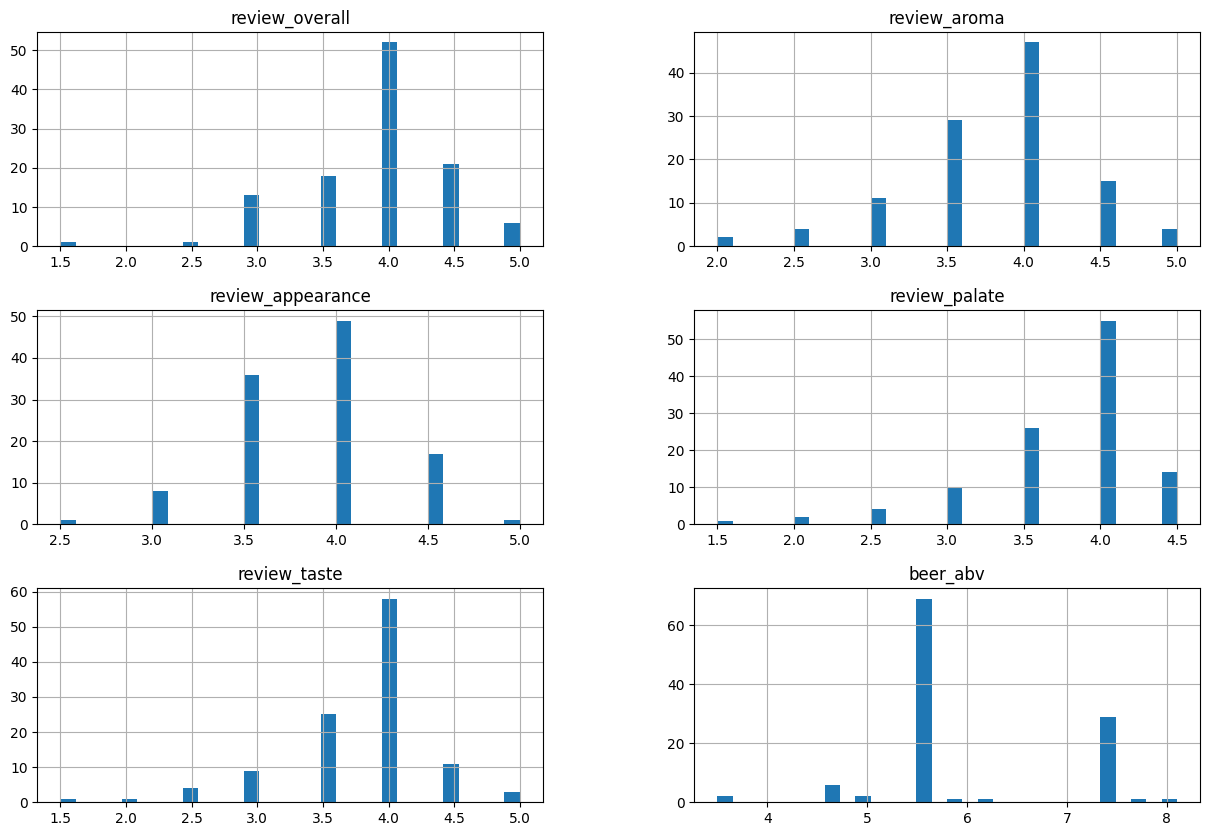

In [86]:
X_train.hist(bins=30, figsize=(15, 10))

In [87]:
len(X_train[X_train['beer_abv'] > 31])
len(X_train[X_train['beer_abv'] > 50])
X_train[X_train['beer_abv'] > 50]

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv


Looks like there exist really that strong beers.

## Feature Selection

In [88]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [89]:
clf = RandomForestClassifier(n_estimators=20, max_features=100).fit(words_train, y_train)
model = SelectFromModel(clf, prefit=True)
words_new = model.transform(words_train)
words_new

/Users/chrisizeh/Documents/TU/2023W/ML/ML-NN-Parameter-Search/.venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


,ale,pale
6,0,0
27,0,0
78,1,1
145,1,1
38,0,0
...,...,...
71,1,1
106,1,1
14,0,0
92,1,1


In [90]:
# words_new = words_train[words_train.columns[:100]]

In [91]:
words_train.index.equals(X_train.index)

True

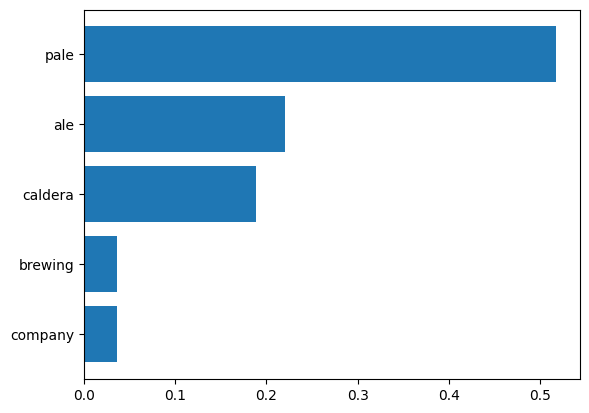

In [92]:
f_i = list(zip(clf.feature_names_in_,clf.feature_importances_))
f_i.sort(key = lambda x : x[1])
f_i = f_i[:20]
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [93]:
X_train_bag = X_train.merge(words_new, how='inner', left_index=True, right_index=True)

In [94]:
X_train_bag

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,ale,pale
6,3.5,3.5,3.5,4.0,4.0,4.7,0,0
27,4.5,5.0,4.0,4.0,4.0,7.4,0,0
78,4.0,3.5,3.5,4.0,4.5,5.5,1,1
145,3.5,3.5,4.5,4.0,3.0,5.5,1,1
38,3.5,3.5,4.5,4.0,3.5,7.4,0,0
...,...,...,...,...,...,...,...,...
71,3.5,4.0,3.5,3.5,4.0,5.5,1,1
106,4.0,4.0,4.0,3.0,3.5,5.5,1,1
14,3.5,4.0,3.0,3.0,4.0,4.7,0,0
92,4.0,4.0,4.0,4.0,3.5,5.5,1,1


In [95]:
X_valid_bag = X_valid.merge(words_valid[words_new.columns], how='inner', left_index=True, right_index=True)
X_valid_bag

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,ale,pale
137,4.0,4.0,3.5,4.0,4.0,5.5,1,1
30,3.0,2.0,2.0,2.0,3.0,3.5,0,0
119,4.0,3.5,3.5,3.5,3.5,5.5,1,1
29,4.5,4.5,4.0,4.0,4.0,7.4,0,0
142,3.5,4.0,3.5,4.0,3.5,5.5,1,1
161,4.0,4.0,4.0,3.5,3.5,5.5,1,1
164,3.5,3.5,3.5,4.0,4.0,5.5,1,1
51,3.5,3.5,4.0,3.5,3.5,7.4,0,0
105,4.5,4.5,4.5,4.5,4.5,5.5,1,1
60,4.0,4.5,4.0,3.5,4.0,7.4,0,0


In [96]:
del words
del words_new
del words_valid
del words_train

In [ ]:
X_valid_bag.to_csv('../data/beer_target_valid.csv')
y_valid.to_csv('../data/beer_valid.csv')
X_train_bag.to_csv('../data/beer_train.csv')
y_train.to_csv('../data/beer_target_train.csv')